## Create Edge List
Creates an edge list for each patch in a provided patch raster and cost surface

In [1]:
#Import libraries
import arcpy
from arcpy.sa import *
import numpy as np
import pandas as pd
import networkx as nx


#Set workspaces
arcpy.env.workspace = 'C:/Workspace/PronghornConnectivity/PronghornConnectivity.gdb'
arcpy.env.scratchWorkspace = 'C:/Workspace/PronghornConnectivity/Scratch/Scratch.gdb'
arcpy.env.overwriteOutput = True

In [2]:
def msg(txt):
    print(txt)
    arcpy.AddMessage(txt)
    return

In [3]:
def edge_threshold(G, max_wt):
   import networkx as nx
   """
   Accepts a (dense) weighted graph (XGraph) and a threshold weight,
   returnsa new graph with only edges for which the weight is
   less than the threshold.  The weights are general but this has been
   designed for (and tested with) distances.

   Usage:  if G is a XGraph with edges < 5000 m,
   >>> G2 = edge_threshold(G, 3000)
   returns a new graph with edges < 3000 m.

   DL Urban (22 Feb 2007)
   Added NetworkX version checking - 26 May 2009; JP Fay
   """

   tG = nx.Graph()
   G_edges = G.edges(data=True)
     
   nbunch = G.nodes()
   tG.add_nodes_from(nbunch)   # copy the nodes

   for edge in G_edges:
       (tn, fn, w) = edge
       if w <= max_wt:
           tG.add_edge(tn, fn, w)
   return tG

In [4]:
def edge_threshold_sequence(G, min_wt, max_wt, winc):
   import networkx as nx
   """
   Accepts a (dense) graph and systematically redefine its
   edges by edge-thresholding it in a loop of calls to
   edge_threshold (above), the loop provided by a min, max,
   and increment.  Note (below) that the increment is added to
   the max_wt to make sure max_wt is included in the range
   (this is because of the way python does loops).
   Returns a dictionary of graphs keyed by the threshold weights.

   Usage:  if G is a dense XGraph with edge weights <= 10000 m,
   >>> Gts = edge_threshold_sequence(G,1000,10000,1000)
   returns a dictionary of of 10 new graphs keyed by the numbers
   1000-10000.  To grab one:
   >>> G4000 = Gts[4000]

   DL Urban (22 Feb 2007)
   Added NetworkX version checking - 26 May 2009; JP Fay
   """

   Gts = {}
   nbunch = G.nodes()
   edges = G.edges(data=True)

   for wt in range(min_wt, max_wt+winc, winc):
       tGw = nx.Graph()
       tGw.add_nodes_from(nbunch)
       for e in edges:
           (n1, n2, w) = e
           if w['weight'] <= wt:
               tGw.add_edge(n1, n2, length=w)
       Gts[wt] = tGw
   return Gts

In [5]:
#   Assess a dictionary of graphs keyed by dispersal distance
#   threshold, in terms of number of components and diameter.

def graph_comp_sequence(Gts):
   import networkx as nx
   """
   Gts is a graph thresholding sequence, a dictionary of graphs
   keyed by threshold distance, see edge_threshold_sequence().
   This function takes that sequence and returns the number of
   components in each graph, along with the diameter of the
   largest component in each graph. The output is a dictionary of
   tuples (NC, D(G)) keyed by threshold distance.

   Requires:  x_diameter(G), local function.

   Usage:  The output is intended to be printed to a file (see
   write_table.txt for syntax), so that a plot can be constructed
   that illustrates the number of components and graph diameter
   as a function of distance.

   DL Urban (22 Feb 2007)
   """

   seq = Gts.keys()
   gcs = {}
   for d in seq:
       g = Gts[d]
       if nx.is_connected(g):
           nc = 1
           diam = x_diameter(g)
       else:
           nc = nx.number_connected_components(g)
           # the largest connected component, #0 in the list:
           gc = nx.connected_component_subgraphs(g)[0]
           diam = x_diameter(gc)
       gcs[d] = (nc, diam)
   return gcs

In [38]:
#   Write these out to a file:

def write_graph_comp_sequence(gcs, path):
   """
   Accept a graph component sequence from edge-thresholding, and
   write the output as a table to a file.

   Usage:
   >>> Gts = edge_threshold_sequence(G, min, max, inc),
   >>> gcs = graph_conn_sequence(Gts)
   >>> write_graph_conn_sequence(gcs, path)

   DL Urban (22 Feb 2007)
   """

   f = open(path, 'w')
   f.write('%s\n' % 'Distance, NComps, Diameter')
   for k,v in gcs.items():
       (nc, diam) = v
       f.write('%4d, %5d, %10.3f\n' % (k, nc, diam))
   f.close() 

# x_eccentricity and x_diameter correspond to the NX functions
# but use weighted edges instead of tallying the number of links.

In [7]:
def x_diameter(G, e=None):
    """Return the diameter of the graph G.

    The diameter is the maximum of all pairs shortest path.
    This version calls x_eccentricity (above).
    """
    if e is None:
        e=x_eccentricity(G,with_labels=True)
    return max(e.values())

In [8]:
def x_eccentricity(G, v=None, sp=None, with_labels=False):
    import networkx as nx

    """
    Return the eccentricity of node v in G (or all nodes if v is None).
    The eccentricity is the maximum of shortest paths to all other nodes. 

    This X version is the same as the original eccentricity and related
    functions, but replaces the call to the single_source functions with
    calls to the corresponding Diijkstra functions.  
    Note the native functions are for unweighted graphs, while the
    Dijkstra functions are for weighted graphs.  Even so, the
    edge weights should be non-negative and not floating point. 
    (copied and altered by DL Urban, Feb 2007)

    The optional keyword sp must be a dict of dicts of
    shortest_path_length keyed by source and target.
    That is, sp[v][t] is the length from v to t.
       
    If with_labels=True 
    return dict of eccentricities keyed by vertex.
    """
    nodes=[]
    if v is None:              # none, use entire graph 
        nodes=G.nodes() 
    elif isinstance(v, list):  # check for a list
        nodes=v
    else:                      # assume it is a single value
        nodes=[v]

    e={}
    for v in nodes:
        if sp is None:
            length=nx.single_source_dijkstra_path_length(G,v)
        else:
            length=sp[v]
        try:
            assert len(length)==G.number_of_nodes()
        except:
            raise (nx.NetworkXError,
                  "Graph not connected: infinite path length")
            
        e[v]=max(length.values())

    if with_labels:
        return e
    else:
        if len(e)==1: return e.values()[0] # return single value
        return e.values()


# Sensi_diameter computes the change in graph diameter
# on the removal of each node--a way to find cut-nodes 
# that are also central to the graph.
# Its helper function (following) writes the output.

In [9]:
def sensi_diameter(G):
    import networkx as nx
    
    """
    Compute graph sensitivity to node removal, in terms of
    the difference in graph diameter on the removal of each
    node in turn.
     
    This uses local function x_diameter(G), which is modified
    from networkx.diamter(G) to work on XGraphs.
    
    DL Urban (9 Feb 2007)
    """
    
    # Starting diameter for full graph:
    
    if nx.is_connected(G):
        d0 = x_diameter(G)
    else:
        G0 = nx.connected_component_subgraphs(G) [0] # the largest subgraph
        d0 = x_diameter(G0)
        nc = nx.number_connected_components(G)	     # how many are there?
    
    sensi = {}
    
    for node in G.nodes():
        ex = G.edges(node) 		# a set of edges adjacent to node; 
        G.delete_edges_from(ex)		# remove all of these,
        G.delete_node(node)		# and then kill the node, too
        if nx.is_connected(G):
            dx = x_diameter(G)
            cuts = 0
        else:
            Gx = nx.connected_component_subgraphs(G) [0]	# the biggest
            ncx = nx.number_connected_components(G)
            if nc == ncx:
                cuts = 0
            else:
                cuts = 1
            dx = x_diameter(Gx)
        delta = d0 - dx
        G.add_node(node)		# put the node and edges back again
        G.add_edges_from(ex)
        sensi[node] = (cuts, delta)
 

    # create and return a tuple (cuts, delta)
    return sensi


#   Write this output to a CSV file:

In [10]:
def write_sensi_diameter(sensi, path):
    f = open(path, 'w')
    f.write('Node, Cuts, deltaD\n')
    for k,v in sensi.iteritems():
        (cuts, delta) = v
        f.write('%4d, %3d, %10.2f\n' % (k, cuts, delta))
    f.close()

In [48]:
# Build graph from edgelist
msg("Building graph from %s" %edgeFile)
G = nx.Graph()
edgeList = open(edgeFile, 'r')
lineText = edgeList.readline()
# Check whether the first line is a header line
if (lineText.split(",")[0]).isalpha:
    lineText = edgeList.readline()
while lineText:
    lineData = lineText.split(",")
    u = int(lineData[0])
    v = int(lineData[1])
    w = float(lineData[2][:-1])
    if w <= maxThresh:
        G.add_edge(u,v,weight = w)
    lineText = edgeList.readline()
edgeList.close()

Building graph from ../../Edges2.csv


In [71]:
#Get inputs
edgeFile = '../EdgesList.csv'
minThresh = 20000
maxThresh = 50000
threshInt = 5000
outFile = '../Summary.csv'

Creating thresholded graphs
Calculating graph properties


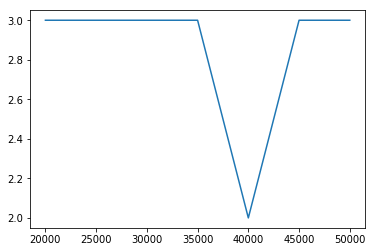

In [72]:
msg("Creating thresholded graphs")
gts = edge_threshold_sequence(G,minThresh,maxThresh,threshInt)

msg("Calculating graph properties")
gcs = graph_comp_sequence(gts)

df = pd.DataFrame(gcs).T
df.columns = ['nc','diam']
df['diam'].plot();

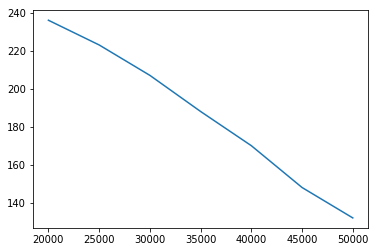

In [73]:
df['nc'].plot();

In [39]:
msg("Writing data to %s" %outFile)
write_graph_comp_sequence(gcs,outFile)

Writing data to ../../Summary.csv
